# Test GloFASv5: Krishna
***

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
from lisflood_read_plot import *

In [3]:
from lisfloodreservoirs import read_timeseries
from lisfloodreservoirs.calibration import get_calibrator, read_results
# from lisfloodreservoirs.calibration.camaflood_calibrator import CamafloodCalibrator
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.models import Camaflood
from lisfloodreservoirs.utils.metrics import KGEmod
from lisfloodreservoirs.utils.utils import return_period

In [4]:
import spotpy

In [5]:
import yaml
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Configuration

In [6]:
path_glofas = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/')

In [7]:
basin = 'Krishna'
station = 6928

In [8]:
# path_resops = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsES/v3.0')

## Data
### Reservoirs

In [9]:
reservoirs = gpd.read_file(path_glofas / 'tables' / 'ReservoirGlofas+GDW+parameters.shp').set_index('GDW_ID')
reservoirs.rename(columns={'flood_stor': 'flood_storage', 'outflow_fa': 'outflow_factor'}, inplace=True)

print(f'{len(reservoirs)} reservoirs in total')

1710 reservoirs in total


### Time series

#### LISFLOOD simulation

In [10]:
path_sim = path_glofas / 'tests' / basin / f'{station}'

# read simulated time series
timeseries = {
    'inflow': read_tss(
        tss=path_sim / 'qresinlong_term_run.tss',
        xml=path_sim.parent / 'OSLisfloodGloFASv5calibration_v1_testEuropeRunlong_term_run.xml'
    ),
    'outflow': read_tss(
        tss=path_sim / 'qresoutlong_term_run.tss',
        xml=path_sim.parent / 'OSLisfloodGloFASv5calibration_v1_testEuropeRunlong_term_run.xml'
    ),
    'storage': read_tss(
        tss=path_sim / 'resfilllong_term_run.tss',
        xml=path_sim.parent / 'OSLisfloodGloFASv5calibration_v1_testEuropeRunlong_term_run.xml'
    ),
}

# convert columns to integer
gdw_ids = []
for var, ts in timeseries.items():
    ts.columns = ts.columns.astype(int)
gdw_ids = ts.columns.tolist()
gdw_ids.sort()

# reorganize by ID
Sim_lisflood = {}
for gdw_id in gdw_ids:
    serie_list = []
    for var, df in timeseries.items():
        serie = df[gdw_id]
        serie.name = var
        if var == 'storage':
            cap_cm = reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6
            serie *= cap_cm
        serie_list.append(serie)
    Sim_lisflood[gdw_id] = pd.concat(serie_list, axis=1)

# clip reservoirs to those simulated
reservoirs = reservoirs.loc[Sim_lisflood.keys()]

print(f'{len(reservoirs)} reservoirs with simulated time series')

14 reservoirs with simulated time series


### Observed

In [86]:
# discharge in the station downstream
file = path_sim / 'HDMS' / 'timeseries' / f'{station}.csv'
if file.is_file():
    obs_dis = pd.read_csv(file, parse_dates=True, index_col=0).squeeze()

In [87]:
# reservoir volume
obs_vol = pd.read_csv(path_sim / 'GWW' / 'Surface Water Volume (#89945).csv', parse_dates=True, index_col=0).squeeze()
obs_vol.index = pd.to_datetime(obs_vol.index, format='mixed', yearfirst=True)

In [12]:
# # read observed time series
# Obs = read_timeseries(
#     path=path_resops / 'time_series' / 'csv',
#     reservoirs=reservoirs.loc[Sim_lisflood.keys(), 'GRAND_ID'].astype(int).tolist(),
#     variables=['inflow', 'outflow', 'storage']
# )
# # convert GRAND_ID to GDW_ID 
# Obs = {reservoirs.loc[reservoirs.GRAND_ID == grand_id].index.item(): ts for grand_id, ts in Obs.items()}
# # # convert storage to filling
# # for gdw_id, ts in Obs.items():
# #     ts['storage'] /= reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6

# print(f'{len(Obs)} reservoirs with observed time series')

## Analysis

In [13]:
path_plots = path_sim / 'plots'
path_plots.mkdir(exist_ok=True)

### LISFLOOD calibration

reservoirs:   0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'storage'

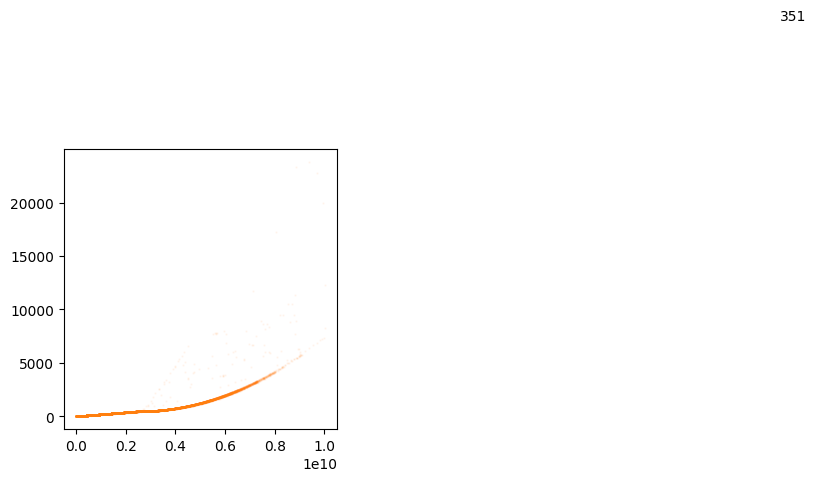

In [57]:
variables = ['inflow', 'storage', 'outflow']
lisflood_performance = pd.DataFrame(index=gdw_ids, columns=[f'KGE_{var}' for var in variables])
for gdw_id in tqdm([351], desc='reservoirs'): #gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reseravoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Vmin = 0.5 * Vf
    Qf = Q100 * par_Qf
    Qmin = 0.5 * Qn

    # reservoir limits
    Vlims = [Vmin, Vf, Ve, cap_cm]
    Qlims = [Qmin, Qf, Qf, Qf]

    # declare reservoir
    res = Camaflood(
        Vmin=Vmin,
        Vf=Vf,
        Ve=Ve,
        Vtot=cap_cm,
        Qn=Qn,
        Qf=Qf,
        catchment=catch_sm,
        Atot=area_sm,
        # timestep=6*3600
    )

    # time series
    sim = Sim_lisflood[gdw_id]
    # if gdw_id in Obs:
    #     obs = Obs[gdw_id]
    # else:
    #     obs = pd.DataFrame(np.nan, columns=sim.columns, index=sim.index)
        # continue
    
    # compare LISFLOOD vs observation
    res.scatter(
        sim,
        obs,
        norm=False,
        title=gdw_id,
        Vlims=Vlims,
        Qlims=Qlims,
        labels=['Lisflood', 'observed'],
        # save=path_plots / f'{gdw_id}_scatter_lisflood_vs_observed.jpg'
    )

    res.lineplot(
        sim={'GloFAS5': sim},
        obs=obs,
        Vlims=Vlims,
        Qlims=Qlims,
        # spinup=cfg.SPINUP,
        title=gdw_id,
        figsize=(12, 6),
        # save=path_plots / f'{gdw_id}_line_lisflood_vs_observed.jpg'
    )

    if gdw_id == 351:
        break
    # for var in variables:
    #     lisflood_performance.loc[gdw_id, f'KGE_{var}'] = KGEmod(obs[var], sim[var])[0]

***

In [48]:
sim = Sim_lisflood[351]

In [66]:
auxline_props = {'c': 'k', 'ls': ':', 'lw': .5}

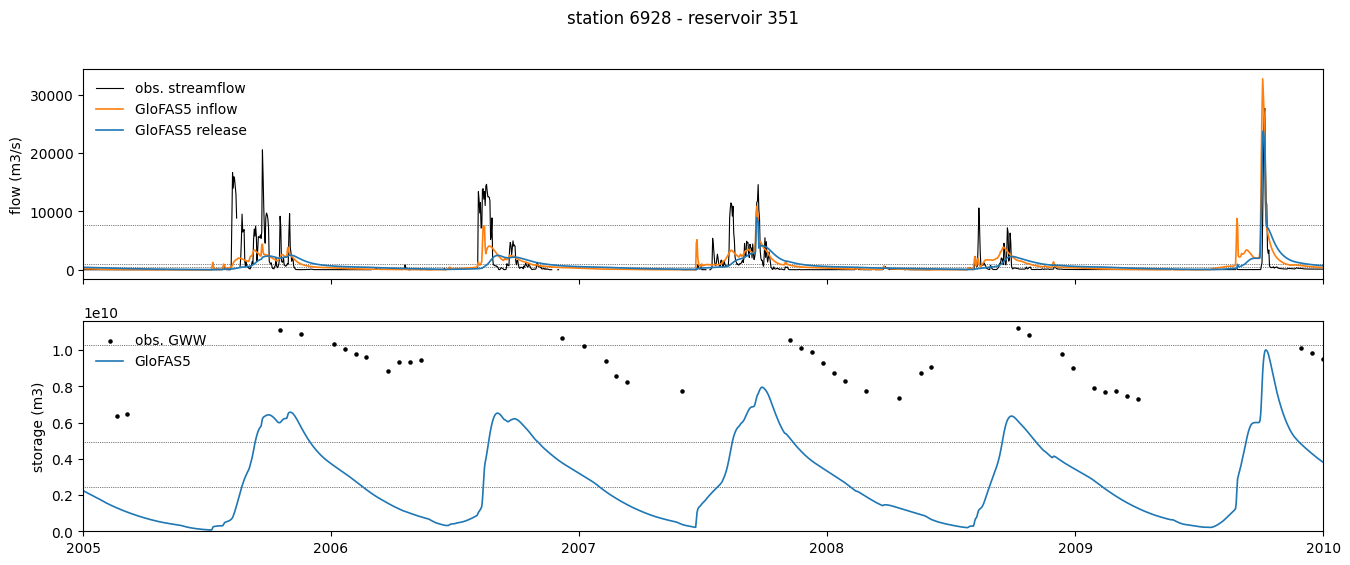

In [101]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 6), sharex=True)

ax[0].plot(obs_dis, c='k', lw=.8, label='obs. streamflow')
ax[0].plot(sim.inflow, c='C1', lw=1.2, label='GloFAS5 inflow')
ax[0].plot(sim.outflow, c='C0', lw=1.2, label='GloFAS5 release')
for y in [Qmin, Qn, Qf]:
    ax[0].axhline(y, **auxline_props, zorder=0)
ax[0].set(
    # xlim=(datetime(1994, 1, 1), datetime(1999, 1, 1)),
    xlim=(datetime(2005, 1, 1), datetime(2010, 1, 1)),
    ylabel='flow (m3/s)'
)
ax[0].legend(frameon=False)

ax[1].scatter(obs_vol.index, obs_vol * 1e9, c='k', s=5, label='obs. GWW')
ax[1].plot(sim.storage, c='C0', lw=1.2, label='GloFAS5')
for y in [Vmin, Vf, Ve]:
    ax[1].axhline(y, **auxline_props, zorder=0)
ax[1].set(
    ylim=(0, cap_cm),
    ylabel='storage (m3)'
)
ax[1].legend(frameon=False)

fig.suptitle(f'station {station} - reservoir 351')
plt.show()

***

In [ ]:
path_obs = Path('Z:/nahaUsers/grimast/EFAS1rcmin_GitLFS_efas5_24032023/calibration_efas5_24032023')

In [ ]:
streamflow = pd.read_csv(path_obs / 'Qts_calib_9021.csv', usecols=['Timestamp', '626'], index_col='Timestamp')
streamflow.index = pd.to_datetime(streamflow.index)
streamflow.columns = df.columns.astype(int)
# df = df.loc[df.first_valid_index(), df.last_valid_index()]

In [ ]:
streamflow.index

In [ ]:
streamflow = streamflow.groupby(streamflow.index.floor('D')).mean()

In [ ]:
release = Obs[1423]

In [ ]:
df = pd.concat((streamflow, release), axis=1).dropna(axis=0, how='any')

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(df.iloc[:, 0], df.iloc[:, 1], s=5, alpha=.5)
ax.plot([0, 500], [0, 500], c='k', ls='--')
ax.set(
    xlabel='streamflow', 
    ylabel='release'
);

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df, label='station')
ax.plot(Obs[1423], label='release')

In [ ]:
Obs[1423].outflow.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(df[626])
ax.plot(df[[637, 2809]].sum(axis=1))


In [ ]:
df.shape

***

In [ ]:
path = Path('Z:/nahaUsers/casadje/EFASv6/reservoirs/tests/Ebro/efas_626/long_term_run')

In [ ]:
dis = read_tss(path / 'dis.tss')
res_outflow = read_tss(path / 'res_outflow.tss')
res_inflow = read_tss(path / 'res_inflow.tss')
theta2 = read_tss(path / 'th2AvUps.tss')
lzup = read_tss(path / 'lzUps.tss')
tl = read_tss(path / 'TransLossQAvgTS.tss')

fig, axes = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)#, sharey=True)
for ax, serie in zip(axes, [theta2, lzup, tl]): #[res_inflow, res_outflow, dis]):
    ax.plot(serie)

In [ ]:
res_inflow.sum() / res_outflow.sum()

In [ ]:
res_outflow = read_tss(path / 'res_outflow.tss')
dis.plot()

In [ ]:
res_inflow = read_tss(path / 'res_inflow.tss')
dis.plot()

***

In [ ]:
sim_camaflood = {}
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    # compare LISFLOOD vs observation
    x_thr = [0.5 * Vf, Vf, Ve, cap_cm]
    y_thr = [0.5 * Qn, Qf, Qf, Qf]
    x1lim = (0, cap_cm)
    reservoir_analysis(
        sim=Sim_lisflood[gdw_id],
        obs=obs[gdw_id],
        title=gdw_id,
        x_thr=x_thr,
        y_thr=y_thr,
        x1lim=x1lim,
        labels=['Lisflood', 'observed'],
        save=path_plots / f'{gdw_id}_lisflood_vs_observed.jpg'
    )


### CaMa-Flood simulation

Simulation of the CaMa-Flood routine with the inflow simulated with the new GloFAS setup.

In [ ]:
sim_camaflood = {}
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    # declare CaMa-Flood reservoir
    res = Camaflood(
        Vmin=0.5 * Vf,
        Vf=Vf,
        Ve=Ve,
        Vtot=cap_cm,
        Qn=Qn,
        Qf=Qf,
        catchment=catch_sm,
        Atot=area_sm,
        timestep=86400,
    )

    # simulate with Lisflood inflow
    ts = res.simulate(Sim_lisflood[gdw_id].inflow)
    # ts.storage /= cap_cm
    sim_camaflood[gdw_id] = ts

    # compare Lisflood vs CaMa-Flood
    x_thr = [0.5 * Vf, Vf, Ve, cap_cm]
    y_thr = [0.5 * Qn, Qf, Qf, Qf]
    x1lim = (0, cap_cm)
    reservoir_analysis(
        sim=Sim_lisflood[gdw_id],
        obs=sim_camaflood[gdw_id],
        title=gdw_id,
        x_thr=x_thr,
        x1lim=x1lim,
        y_thr=y_thr,
        labels=['Lisflood', 'CaMa-Flood'],
        save=path_plots / f'{gdw_id}_lisflood_vs_camaflood.jpg'
    )

### CaMa-Flood calibration

In [ ]:
path_calib = path_sim / 'camaflood'
path_calib.mkdir(exist_ok=True)

# sim_camaflood = {}
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    # set up the calibrator
    calibrator = Camaflood_calibrator_2par(
        inflow=Sim_lisflood[gdw_id].loc[start:end, 'inflow'],
        storage=obs[gdw_id].loc[start:end, 'storage'],
        outflow=obs[gdw_id].loc[start:end, 'outflow'],
        Vmin=max(0, min(0.1 * cap_cm, obs[gdw_id].storage.min())),
        Vtot=cap_cm,
        catchment=catch_sm,
        # Atot=area_sm,
        target=['storage', 'outflow'],
        obj_func=KGEmod,
        spinup=None,
    )

    # define the sampling method
    dbname = f'{path_calib}/{gdw_id}_samples'
    sceua = spotpy.algorithms.sceua(
        calibrator, 
        dbname=dbname, 
        dbformat='csv', 
        # parallel='mpi' if args.parallel else 'seq',
        save_sim=False,
        # seed=42
    )

    # launch calibration
    sceua.sample(
        4000, 
        ngs=8, 
        kstop=3, 
        pcento=0.01, 
        peps=0.1
    )

In [ ]:
gdw_id = 1407

In [ ]:
# read calibration results
dbname = f'{path_calib}/{gdw_id}_samples'
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
reservoir = get_model('camaflood', **calibrated_attrs)

In [ ]:
calibrated_attrs

In [ ]:
# export calibrated parameters
with open(path_calib / f'{gdw_id}_optimal_parameters.yml', 'w') as file:
    yaml.dump(reservoir.get_params(), file)

In [ ]:
# simulate the reservoir
Vo = obs[gdw_id].loc[start, 'storage'] #ts.storage.iloc[0]
sim = reservoir.simulate(
    inflow=Sim_lisflood[gdw_id].loc[start:end, 'inflow'],
    Vo=None if pd.isna(Vo) else Vo,
)
# sim_cal.to_csv(cfg.PATH_CALIB / f'{grand_id}_simulation.csv', float_format='%.3f')

In [ ]:
# extract reservoir characteristics
cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
# extract inflow characteristics
Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
# extract reservoir parameters
par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

k = max(1 - 5 * (cap_cm - Vf) / catch_sm, 0)
print(f'{gdw_id}\tk = {k:.3f}')

# define reservoir limits
Vf = par_Vf * cap_cm
Ve = cap_cm * (0.8 + 0.2 * par_Vf)
Qf = Q100 * par_Qf

year_start, year_end = reservoirs.loc[gdw_id, ['YEAR_DAM', 'REM_YEAR']]

fig, axes = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)

flood_mode = (sim.storage > Vf) & (sim.inflow > Qf)

for ax, var in zip(axes, ['storage', 'inflow', 'outflow']):
    ax.scatter(
        sim[flood_mode].index, 
        sim.loc[flood_mode, var], 
        marker='.', 
        s=.8, 
        color='firebrick')
    ax.scatter(
        sim[~flood_mode].index, 
        sim.loc[~flood_mode, var], 
        marker='.', 
        s=.8, 
        color='steelblue'
    )
    if var in ['storage', 'outflow']:
        ax.plot(obs[gdw_id][var], lw=.8, c='k', zorder=0)
    ax.set_ylabel(var)
    
for y in [0.5 * Vf, Vf, Ve, cap_cm]:
    axes[0].axhline(y, ls='--', c='k', lw=.5)
start = max(datetime(int(year_start), 1, 1), sim.first_valid_index()) if year_start else sim.first_valid_index()
end = min(datetime(int(year_end), 12, 31), sim.last_valid_index()) if year_end else sim.last_valid_index()
ax.set_xlim(start, end)

for y in [0.5 * Qn, Qf]:
    axes[1].axhline(y, ls='--', c='k', lw=.5)
    axes[2].axhline(y, ls='--', c='k', lw=.5)

axes[0].set_title(f'{gdw_id} | k = {k:.3f}');

# plt.savefig(path_plots / f'{gdw_id}_timeseries.jpg', dpi=300, bbox_inches='tight')

In [ ]:
(1 - results.like1).plot()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
sct = ax.scatter(
    x=results.alpha, 
    y=results.delta, 
    c=(1 - results.like1), 
    s=8,
    cmap='coolwarm_r', 
    alpha=.5,
    # vmin=-1, 
    # vmax=1
)
ax.set(
    xlabel='flood storage',
    ylabel='flood outflow',
    title=gdw_id,
)
plt.colorbar(sct, shrink=.5, label="KGE'");

***

In [ ]:
for gdw_id, sim in tqdm(Sim_lisflood.items(), desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    k = max(1 - 5 * (cap_cm - Vf) / catch_sm, 0)
    print(f'{gdw_id}\tk = {k:.3f}')

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    year_start, year_end = reservoirs.loc[gdw_id, ['YEAR_DAM', 'REM_YEAR']]

    
    fig, axes = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)
    
    flood_mode = (sim.storage > Vf) & (sim.inflow > Qf)
    
    for ax, var in zip(axes, ['storage', 'inflow', 'outflow']):
        ax.scatter(
            sim[flood_mode].index, 
            sim.loc[flood_mode, var], 
            marker='.', 
            s=.8, 
            color='firebrick')
        ax.scatter(
            sim[~flood_mode].index, 
            sim.loc[~flood_mode, var], 
            marker='.', 
            s=.8, 
            color='steelblue'
        )
        if var in ['storage', 'outflow']:
            ax.plot(obs[gdw_id][var], lw=.8, c='k', zorder=0)
        ax.set_ylabel(var)
        
    for y in [0.5 * Vf, Vf, Ve, cap_cm]:
        axes[0].axhline(y, ls='--', c='k', lw=.5)
    start = max(datetime(int(year_start), 1, 1), sim.first_valid_index()) if year_start else sim.first_valid_index()
    end = min(datetime(int(year_end), 12, 31), sim.last_valid_index()) if year_end else sim.last_valid_index()
    ax.set_xlim(start, end)
    
    for y in [0.5 * Qn, Qf]:
        axes[1].axhline(y, ls='--', c='k', lw=.5)
        axes[2].axhline(y, ls='--', c='k', lw=.5)
    
    axes[0].set_title(f'{gdw_id} | k = {k:.3f}');
    
    plt.savefig(path_plots / f'{gdw_id}_timeseries.jpg', dpi=300, bbox_inches='tight')

In [ ]:
year_start, year_end

In [ ]:
reservoirs.loc[gdw_ids, 'parameters']

In [ ]:
cap_cm, catch_sm = reservoirs.loc[1410, ['CAP_MCM', 'CATCH_SKM']] * 1e6
cap_cm, catch_sm

In [ ]:
cap_cm, Vf, catch_sm

In [ ]:
(cap_cm - Vf) / catch_sm

In [ ]:
catch_sm

In [ ]:
cap_mcm, catch_skm, area_skm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']].values

In [ ]:
cap_mcm

***
### CaMa-Flood calibration 3 pars

In [ ]:
import seaborn as sns

In [ ]:
path = path_resops / 'tests' / '3_pars'

In [ ]:
subpath = Path('camaflood/calibration/bivariate')

In [ ]:
grand_id = 2662

In [ ]:
for grand_id in [2662, 2677, 2684]:
    
    iterations, parameters = read_results(path / subpath / f'{grand_id}_samples.csv')
    
    sns.pairplot(
        iterations[['alpha', 'delta', 'k', 'like1']], 
        hue='like1',
        palette='coolwarm',
        diag_kind='kde',
        corner=False
    );

### Compare tests

In [ ]:
path = path_resops / 'results' / 'hanazaki_2pars' / 'calibration' / 'bivariate'
for grand_id in [2662, 2677, 2684]:
    print(grand_id)
    iterations, parameters = read_results(path / f'{grand_id}_samples.csv')
    best_iter = iterations.like1.idxmin()
    print(iterations.loc[best_iter])

In [ ]:
path = path_resops / 'results' / 'hanazaki_2pars' / 'calibration' / 'bivariate'
for grand_id in [2662, 2677, 2684]:
    print(grand_id)
    sim = pd.read_csv(path / f'{grand_id}_simulation.csv', parse_dates=True, index_col='date')
    rps = return_period(sim.outflow, T=np.array([5, 10, 20, 100]))
    print(rps, sep='\t')

In [ ]:
tests = ['3_pars', 'k_01', 'k_05', 'k_1']

for test in tests:
    print(test)
    for grand_id in [2662, 2677, 2684]:
        print(grand_id)
        path = path_resops / 'tests' / test
        iterations, parameters = read_results(path / subpath / f'{grand_id}_samples.csv')
        best_iter = iterations.like1.idxmin()
        print(iterations.loc[best_iter])

In [ ]:

for test in tests:
    print(test)
    for grand_id in [2662, 2677, 2684]:
        path = path_resops / 'tests' / test
        sim = pd.read_csv(path / subpath / f'{grand_id}_simulation.csv', parse_dates=True, index_col='date')
        rps = return_period(sim.outflow, T=np.array([5, 10, 20, 100]))
        print(grand_id, rps, sep='\t')